In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdflib import Literal, RDF, URIRef
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
import rdflib.namespace
from owlready2 import *
from owlready2 import get_ontology
import networkx as nx
import networkx.algorithms.community as nx_comm

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


In [2]:
onto = get_ontology("http://example.org/medsur.owl")

In [3]:
class Patients(Thing):
    namespace = onto

class AgeGroup(Thing):
    namespace = onto
 
class hasAgeGroup(ObjectProperty):                 
    domain = [Patients]
    range = [AgeGroup]
    namespace = onto
  
class WeightGroup(Thing):
    namespace = onto
    
class hasWeightGroup(ObjectProperty):   
    domain = [Patients]
    range = [WeightGroup]
    namespace = onto
  
class SOC(Thing):  #System Organ Class
    namespace = onto
      
class hasSOC(ObjectProperty):
    domain = [Patients]
    range = [SOC]
    namespace = onto
    
class HLGT(SOC):  #High Level Group Term
    namespace = onto
    
class hasHLGT(ObjectProperty):
    domain = [Patients]	
    range = [HLGT]
    namespace = onto

class HLT(HLGT):  #High Level Term
    namespace = onto
    range = [HLGT]
    namespace = onto

class hasHLT(ObjectProperty):
    domain = [Patients]
    range = [HLT]
    namespace = onto
    
class PT(HLT):  #Preferred Term 
    namespace = onto
    
class hasPT(ObjectProperty):
    domain = [Patients]
    range = [PT]
    namespace = onto

class LLT(PT):  #Low Level Term
    namespace = onto
    
class hasLLT(ObjectProperty):  
    domain = [Patients]
    range = [LLT]
    namespace = onto

class Outcome(Thing):
    namespace = onto
    
class hasOutcome(ObjectProperty):
    domain = [Patients]
    range = [Outcome]
    namespace = onto
    
class Gender(Thing):
    namespace = onto

class hasGender(ObjectProperty):
    domain = [Patients]
    range = [Gender]
    namespace = onto

class Drug(Thing):
    namespace = onto
    
class IsGivenDrug(ObjectProperty):
    domain = [Patients]
    range = [Drug]
    namespace = onto
    
class IsOfDosis(ObjectProperty):
    domain = [Drug]
    namespace = onto
    
class IsOfType(ObjectProperty):
    domain = [Drug]
    namespace = onto

class SideEffects(PT):   # subclass of PT
    namespace = onto
    
class hasSideEffect(ObjectProperty):
    domain = [Drug]
    range = [SideEffects]
    namespace = onto
    
class hasFrequency(ObjectProperty):                 
    domain = [SideEffects]
    namespace = onto 
    
class suffersSideEffects(ObjectProperty):
    domain = [Patients]
    range = [SideEffects]
    namespace = onto

In [4]:
# save the ontology
onto.save(file = "medsur.rdf", format = "rdfxml") 
g = rdflib.Graph()
g.parse("medsur.rdf", format="xml")

# Loop through each triple in the graph (subj, pred, obj)
for subj, pred, obj in g:
    
    # Check if there is at least one triple in the Graph
    if (subj, pred, obj) not in g:
       raise Exception("It better be!")

# Print the number of "triples" in the Graph
print(f"Graph g has {len(g)} statements.")

Graph g has 67 statements.


In [5]:
# print all the triples in the graph 
for s, p, o in g:
    print(s, p, o)

http://example.org/medsur.owl#SOC http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Class
http://example.org/medsur.owl#PT http://www.w3.org/2000/01/rdf-schema#subClassOf http://example.org/medsur.owl#HLT
http://example.org/medsur.owl#hasFrequency http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#ObjectProperty
http://example.org/medsur.owl#IsGivenDrug http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#ObjectProperty
http://example.org/medsur.owl#hasWeightGroup http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#ObjectProperty
http://example.org/medsur.owl#LLT http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Class
http://example.org/medsur.owl#hasGender http://www.w3.org/2000/01/rdf-schema#range http://example.org/medsur.owl#Gender
http://example.org/medsur.owl#hasWeightGroup http://www.w3.org/2000/01/rdf-schema#range http://example.org/medsur.owl#We

In [6]:
data = pd.read_excel('opioid_datamerged.xlsx')

# add index column
data = data.reset_index()

data_sideeffects = pd.read_excel('sider_output.xlsx')

In [7]:
# add RDF triples to the ontology
EX = rdflib.Namespace("http://example.org/medsur.rdf#")

for index, row in data.iterrows():

    patient = URIRef(f"http://www.medsur.org/patient_{index}")
    g.add((patient, RDF.type, EX.Patients))

    if row["weight_group"] != np.nan:
        weight_group = URIRef(f"http://www.medsur.org/weight/{row['weight_group']}")
        g.add((weight_group, RDF.type, EX.WeightGroup))
        g.add((patient, EX.hasWeightGroup, weight_group))

    if float(row["age_year"]) >= 65:
        agegroup = URIRef("http://www.medsur.org/age/65_above")
    elif float(row["age_year"]) >= 45:
        agegroup = URIRef("http://www.medsur.org/age/45_64") 
    elif float(row["age_year"]) >= 25:
        agegroup = URIRef("http://www.medsur.org/age/25_44")
    elif float(row["age_year"]) >= 18:
        agegroup = URIRef("http://www.medsur.org/age/18_24")
    
    if agegroup:
        g.add((agegroup, RDF.type, EX.AgeGroup))
        g.add((patient, EX.hasAgeGroup, agegroup))

    if row["sex"] == "male" or row["sex"] == "female":
        gender = URIRef(f"http://www.medsur.org/gender/{row['sex']}")
        g.add((gender, RDF.type, EX.Gender))
        g.add((patient, EX.hasGender, gender))

    if row["Outcome"] != "Unknown" and row["Outcome"] != np.nan: 
        outcome = URIRef(f"http://www.medsur.org/outcome/{row['Outcome']}")
        g.add((outcome, RDF.type, EX.Outcome))
        g.add((patient, EX.hasOutcome, outcome))

    if row["SOCCode"] != np.nan:
        soc = URIRef(f"http://www.medsur.org/soc/{row['SOCCode']}")
        g.add((soc, RDF.type, EX.SOC))
        g.add((patient, EX.hasSOC, soc))
        
    if row["HLTGCode"] != np.nan:
        hlgt = URIRef(f"http://www.medsur.org/hlgt/{row['HLTGCode']}")
        g.add((hlgt, RDF.type, EX.HLGT))
        g.add((patient, EX.hasHLGT, hlgt))
        
    if row["HLTCode"] != np.nan:
        hlt = URIRef(f"http://www.medsur.org/hlt/{row['HLTCode']}")
        g.add((hlt, RDF.type, EX.HLT))
        g.add((patient, EX.hasHLT, hlt))
    
    if row["PTCode"] != np.nan:
        pt = URIRef(f"http://www.medsur.org/symptom/{row['PTCode']}")
        g.add((pt, RDF.type, EX.PT))
        g.add((patient, EX.hasPT, pt))
        
    if row["LLTCode"] != np.nan:
        lt = URIRef(f"http://www.medsur.org/symptom/{row['LLTCode']}")
        g.add((lt, RDF.type, EX.LLT))
        g.add((patient, EX.hasLLT, lt))

    if row["ATCode"] != np.nan:
        drug = URIRef(f"http://www.medsur.org/drug/{row['ATCode']}")              
        g.add((drug, RDF.type, EX.Drug))   
        g.add((patient, EX.isGivenDrug, drug))

    # get all side effects for the drug
    df_sideeffects = data_sideeffects.loc[data_sideeffects['ATCode'] == row["ATCode"]]
  
    for index, row2 in df_sideeffects.iterrows():
        
        # check if any side_effect is present in patient file under symptoms (PTCode based)
        if row2["PTCode"] != np.nan and row2["PTCode"] != "nan":
            
            side_effect = URIRef(f"http://www.medsur.org/side_effect/{row2['PTCode']}")
            g.add((side_effect, RDF.type, EX.SideEffects))
            g.add((drug, EX.hasSideEffect, side_effect))
            
            if row2["Frequency"] != np.nan and row2["Frequency"] != "nan":

                g.add((side_effect, EX.hasFrequency, frequency))
                
    # check if any side_effect is present in patient file
    if row['is_sideeffect'] == True and row['PTCode'] != np.nan:      
        g.add((patient, EX.suffersSideEffect, Literal("yes")))     
    else:
        g.add((patient, EX.suffersSideEffect, Literal("no")))   

In [8]:
# run a reasoner
with onto: 
    sync_reasoner(infer_property_values = True)

* Owlready2 * Running HermiT...
    java -Xmx2000M -cp c:\Users\agnes\anaconda3_nieuw\lib\site-packages\owlready2\hermit;c:\Users\agnes\anaconda3_nieuw\lib\site-packages\owlready2\hermit\HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:///C:/Users/agnes/AppData/Local/Temp/tmp4lx2tufi -Y
* Owlready2 * HermiT took 1.6423420906066895 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [9]:
# checks for inconsistencies in the ontology
list(default_world.inconsistent_classes())

[]

In [10]:
# create a networkx graph from the RDF graph
nx_graph = rdflib_to_networkx_digraph(g)

# save ttl file
g.serialize(destination='medsur.ttl', format='turtle')

<Graph identifier=N7db7bf11a6ac47a2b01964bcc0d9d168 (<class 'rdflib.graph.Graph'>)>

In [11]:
# print some stats
print("Number of Nodes: {n}".format(n=nx.number_of_nodes(nx_graph)))
print("Number of Edges: {n}".format(n=nx.number_of_edges(nx_graph)))
print("Density of Graph: {n}".format(n=nx.density(nx_graph)))
print("Clustering coefficient: {n}".format(n=nx.average_clustering(nx_graph)))
print("Degree centrality:", nx.degree_centrality(nx_graph))

Number of Nodes: 19017
Number of Edges: 171302
Density of Graph: 0.0004736976806328921
Clustering coefficient: 4.318305312152922e-05
Degree centrality: {rdflib.term.URIRef('http://www.medsur.org/patient_6292'): 0.0005784602440050484, rdflib.term.URIRef('http://example.org/medsur.rdf#Patients'): 0.7704038704249053, rdflib.term.URIRef('http://www.medsur.org/side_effect/10002199'): 0.0006836348338241481, rdflib.term.Literal('0.00055', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#double')): 0.0017353807320151452, rdflib.term.URIRef('http://www.medsur.org/patient_6334'): 0.0005784602440050484, rdflib.term.URIRef('http://www.medsur.org/gender/female'): 0.5075199831720656, rdflib.term.URIRef('http://www.medsur.org/patient_13739'): 0.0005784602440050484, rdflib.term.URIRef('http://www.medsur.org/weight/nan'): 0.40213504417332774, rdflib.term.URIRef('http://www.medsur.org/patient_3448'): 0.0005784602440050484, rdflib.term.URIRef('http://www.medsur.org/soc/10018065'): 0.11858435

Mean degree: 18.015670189830153
Mean degree centrality: 0.0009473953612657843


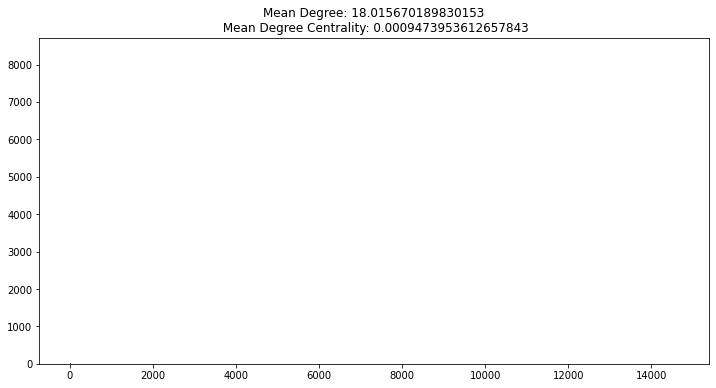

In [12]:
# plot the degree distribution (degree = number of edges)
histdegree = pd.DataFrame(nx.degree_histogram(nx_graph))
degree = dict(nx.degree(nx_graph))

mean_degree = np.mean(list(degree.values()))
mean_degree_centrality = np.mean(list(nx.degree_centrality(nx_graph).values()))

print("Mean degree: {n}".format(n=mean_degree))
print("Mean degree centrality: {n}".format(n=mean_degree_centrality))

fig, ax = plt.subplots(figsize=(12,6)) 
ax.bar(histdegree.index.values,histdegree[0])

plt.title("Mean Degree: {n1}\n Mean Degree Centrality: {n2}".format(n1=mean_degree,n2=mean_degree_centrality))
plt.show()


In [13]:
# save the triples in a csv file
with open('medsur.csv', 'w') as f: 
    for s, p, o in g:
        f.write(f'{s},{p},{o} \n')